## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
# import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu",
                                   name = "hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu",
                                   name = "hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax",
                             name = "output_layer")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weights=0.7, focal_weights=0.3):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def CE_Focal_loss(y_true, y_pred):
#         FL(p_t) = -alpha(1-p_t)^{gamma}ln(p_t)
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduce_fl = tf.reduce_max(fl, axis = 1)
    
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weights*ce_loss) + (focal_weights*tf.reduce_mean(reduce_fl))
    return CE_Focal_loss
    
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss = combined_loss(), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Bat

49/49 [==============================] - 2s 47ms/step - loss: 1.5944 - accuracy: 0.6196 - val_loss: 2.2196 - val_accuracy: 0.4811
Epoch 14/25
49/49 [==============================] - 2s 47ms/step - loss: 1.5533 - accuracy: 0.6289 - val_loss: 2.2005 - val_accuracy: 0.4893
Epoch 15/25
49/49 [==============================] - 2s 47ms/step - loss: 1.5033 - accuracy: 0.6429 - val_loss: 2.2065 - val_accuracy: 0.4866
Epoch 16/25
49/49 [==============================] - ETA: 0s - loss: 1.4521 - accuracy: 0.65 - 2s 48ms/step - loss: 1.4523 - accuracy: 0.6512 - val_loss: 2.2061 - val_accuracy: 0.4912
Epoch 17/25
49/49 [==============================] - 2s 49ms/step - loss: 1.4050 - accuracy: 0.6649 - val_loss: 2.2818 - val_accuracy: 0.4766
Epoch 18/25
49/49 [==============================] - 2s 47ms/step - loss: 1.3683 - accuracy: 0.6726 - val_loss: 2.2436 - val_accuracy: 0.4875
Epoch 19/25
49/49 [==============================] - 2s 49ms/step - loss: 1.3109 - accuracy: 0.6855 - val_loss: 2.2741

Epoch 1/25
49/49 [==============================] - 4s 52ms/step - loss: 4.0099 - accuracy: 0.2380 - val_loss: 3.4544 - val_accuracy: 0.1894
Epoch 2/25
49/49 [==============================] - 2s 47ms/step - loss: 2.5992 - accuracy: 0.4128 - val_loss: 3.1443 - val_accuracy: 0.2770
Epoch 3/25
49/49 [==============================] - 2s 46ms/step - loss: 2.3589 - accuracy: 0.4608 - val_loss: 2.8349 - val_accuracy: 0.3646
Epoch 4/25
49/49 [==============================] - 2s 50ms/step - loss: 2.2256 - accuracy: 0.4855 - val_loss: 2.5895 - val_accuracy: 0.4192
Epoch 5/25
49/49 [==============================] - 2s 48ms/step - loss: 2.1139 - accuracy: 0.5110 - val_loss: 2.4444 - val_accuracy: 0.4431
Epoch 6/25
49/49 [==============================] - 2s 47ms/step - loss: 2.0236 - accuracy: 0.5257 - val_loss: 2.3340 - val_accuracy: 0.4608
Epoch 7/25
49/49 [==============================] - 2s 47ms/step - loss: 1.9546 - accuracy: 0.5413 - val_loss: 2.2821 - val_accuracy: 0.4689
Epoch 8/25
49

49/49 [==============================] - 3s 57ms/step - loss: 1.1463 - accuracy: 0.7248 - val_loss: 2.2675 - val_accuracy: 0.4974
Epoch 24/25
49/49 [==============================] - 3s 54ms/step - loss: 1.1062 - accuracy: 0.7344 - val_loss: 2.3138 - val_accuracy: 0.4855
Epoch 25/25
49/49 [==============================] - 3s 52ms/step - loss: 1.0657 - accuracy: 0.7446 - val_loss: 2.3243 - val_accuracy: 0.4808


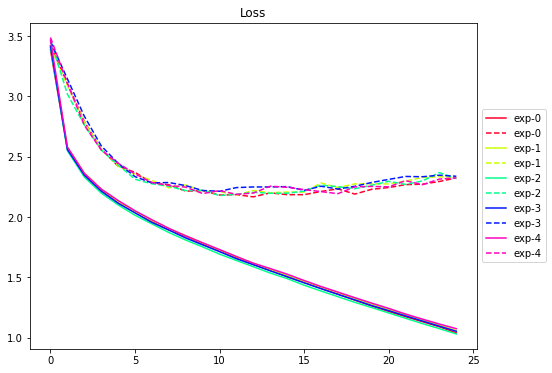

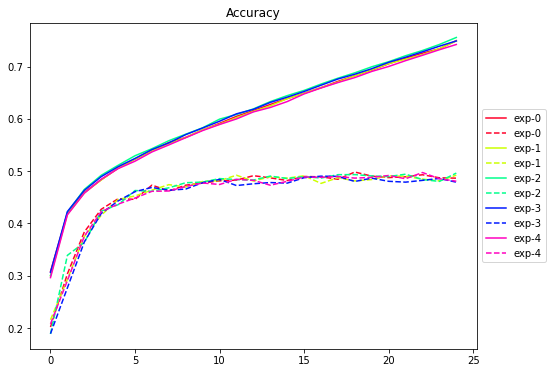

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()